In [2]:
###Import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import sys
sys.path.insert(0, '../analysis')
from models import activation, repression

In [3]:
###Specify if figures are to be saved to PNG
save_figs = True

###Color palette
orders = ['Open Loop', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'Open Loop': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}
color1= (96/255,151/255, 198/255) #light
color2 = (22/255,56/255,104/255) #dark

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/matplotlib/transforms.py:740: UserWarning: Warning: converting a masked element to nan.
  points = np.asarray(points, float)
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


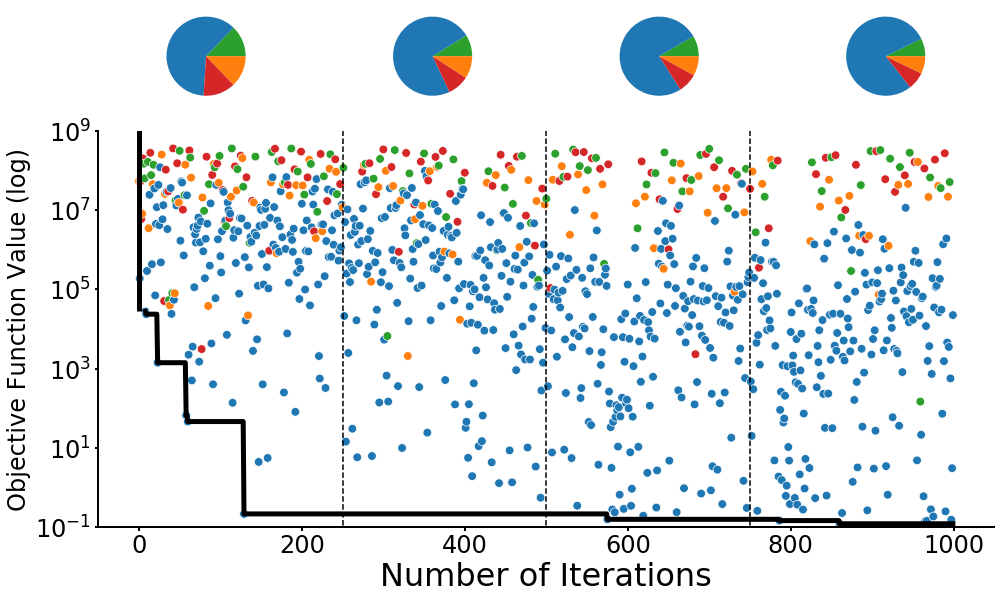

In [3]:
###FIGURE: Sample run

landscape = pd.read_csv('../data/glucaric_acid_sample_run.csv')
fig = plt.figure(figsize=(7*2, 4.22*2))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=32)
ax.set_ylabel('Objective Function Value (log)', fontsize=32)
ax.set_yscale('log')
ax.set_ylim([10E-2, 10E8])
sns.scatterplot(x='index', y='loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False, s=75)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')

prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color='k', linewidth=5)
ax.set_ylabel('Objective Function Value (log)', fontsize=24)
ax.vlines(0, landscape.best_losses[starts], 10E9, color='k', linewidth=5)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

quarter1 = (landscape.iloc[0:250].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
colors = ['tab:green', 'tab:blue', sns.color_palette()[3],  'tab:orange']

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.loss, colors=colors)

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.loss, colors=colors)

fig.tight_layout()
if save_figs: fig.savefig('../figs/glucaric_acid_sample_run.png', dpi=300)

In [4]:
#Read in and clean data from kinetic perturbations
total_perturbs = pd.read_csv('../data/glucaric_acid_kinetic_perturbation.csv')
total_background = pd.read_csv('../data/glucaric_acid_background.csv')
total_background = total_background.loc[total_background.best_loss_circuit != 'best_loss_circuit']
total_perturbs = total_perturbs.loc[total_perturbs.best_loss_circuit != 'best_loss_circuit']

start=0
stop=1000
background = pd.DataFrame(columns=total_background.columns)
total_background['loss'] = [float(loss) for loss in total_background.loss]
for j in range(100):
    landscape = total_background.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E9
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] > 0:
            best_loss = landscape.loss[i]
            if best_loss == 0: print('waa')
            best_row = landscape.loc[landscape['Unnamed: 0'] == i]
    background = pd.concat([background, best_row])
    start = stop
    stop += 1000

start=0
stop=1000
perturbs = pd.DataFrame(columns=total_perturbs.columns)
for j in range(100):
    landscape = total_perturbs.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E9
    for i in range(len(landscape)):
        if float(landscape.loss[i]) < best_loss and float(landscape.loss[i]) > 0:
            best_loss = float(landscape.loss[i])
            best_row = landscape.loc[landscape['index'] == i]
    perturbs = pd.concat([perturbs, best_row])
    start = stop
    stop += 1000

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_45752/870225020.py:2: DtypeWarning: Columns (2,4,5,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  total_perturbs = pd.read_csv('../data/glucaric_acid_kinetic_perturbation.csv')


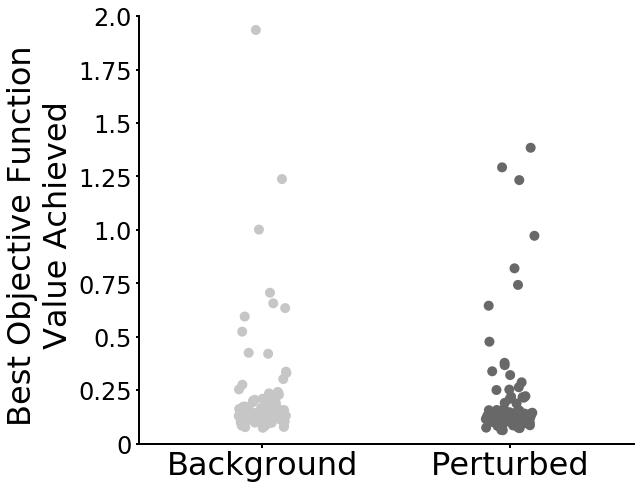

In [10]:
###FIGURE: Objective function values strip plot
x = ['Background', 'Perturbed']
plot_data = pd.DataFrame({'best_loss':background.loss.to_list(), 'type':'Background' })
plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss': perturbs.loss.to_list(), 'type':'Perturbed'})])
plot_data['best_loss'] = [float(p) for p in plot_data.best_loss]
fig, ax = plt.subplots(1, 1,figsize=(9, 2.3*3))
sns.stripplot(data=plot_data, x="type", y="best_loss" , palette='Greys', ax=ax, jitter=True, size=10)
ax.set_ylim([0, 2])
ax.set_xticklabels(x, fontsize=32)
ax.set_yticklabels([0,  0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0], fontsize=24)
ax.set_ylabel('Best Objective Function \n Value Achieved', fontsize=32)
ax.set_xlabel('')

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(width=2)

fig.tight_layout()
if save_figs: fig.savefig('../figs/glucaric_acid_objective_fn_strip.png', dpi=300)

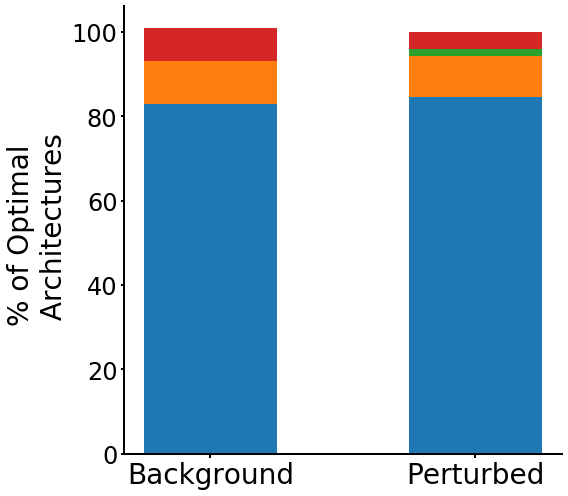

In [12]:
### Figure: Stacked bar of best architectures achieved
background = [83, 10, 0, 8]
singlecolors = ['blue', 'green', 'red' 'orange']
landscape = [846, 96, 18, 40]
x = ['Background', 'Perturbed']
plot_df = pd.DataFrame({'Background':background, 'Perturbed':landscape})

bottom_sum = [0, 0]
fig, ax = plt.subplots(1, 1,figsize=(8, 7))
for i in range(len(plot_df)):
    ax.bar(x, [plot_df.Background[i], plot_df.Perturbed[i]/10], bottom = bottom_sum, width=0.5)
    bottom_sum[0] = bottom_sum[0] + plot_df.Background[i]
    bottom_sum[1] = bottom_sum[1] + plot_df.Perturbed[i]/10

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(width=2)

ax.set_xticklabels(x, fontsize=28)
ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=24)
ax.set_ylabel('% of Optimal \n Architectures', fontsize=28)
fig.tight_layout()
if save_figs: fig.savefig('../figs/glucaric_acid_optimal_arch_stacked_bar.png', dpi=300)

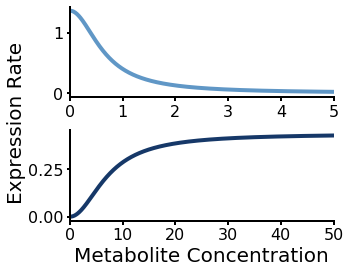

In [5]:
###FIGURE: Dose response curves
single_arch_background = pd.read_csv('../data/glucaric_acid_kinetic_perturbation_singlearch.csv')
dc_background = single_arch_background.loc[single_arch_background.Circuit == 'Dual Control']

start=0
stop=1000
background_singlearch = pd.DataFrame(columns=dc_background.columns)
for j in range(100):
    landscape = dc_background.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E9
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] > 0:
            best_loss = landscape.loss[i]
            best_row = landscape.loc[landscape['index'] == i]
    background_singlearch = pd.concat([background_singlearch, best_row])
    start = stop
    stop += 1000

background_singlearch = background_singlearch.reset_index(drop=True)
xs = np.arange(0, 100, 0.001)

#Compute dose-response curves for all optimal param values
mean_y1 = repression(xs, background_singlearch.k1.mean(), background_singlearch.theta1.mean(), 2.)
mean_y2 = activation(xs, background_singlearch.k2.mean(), background_singlearch.theta2.mean(), 2.)

fig, axs = plt.subplots(2,1,figsize=(3.5*1.3, 3*1.3))
ax = axs[0]
ax.plot(xs, mean_y1, c=color1, linewidth=4)
ax.set_xlim([0, 5])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('')
ax.tick_params(width=2)

fig.tight_layout()

ax = axs[1]
ax.set_xlim([0, 50])
ax.plot(xs, mean_y2, c=color2, linewidth=4)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('')
ax.tick_params(width=2)
ax.set_xlabel(r'Metabolite Concentration', fontsize=20)
fig.text(-0.06, 0.55, 'Expression Rate', va='center', rotation='vertical', fontsize=20)

fig.tight_layout()
if save_figs: fig.savefig('../figs/glucaric_acid_dose_response_curves.png', dpi=300, bbox_inches='tight', pad_inches=0.)


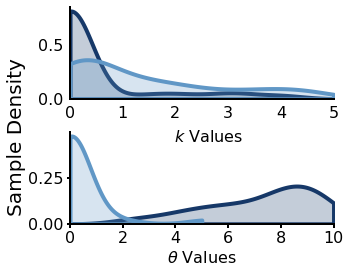

In [7]:
###FIGURE: Parameter distributions
fig, axs = plt.subplots(2,1,figsize=(3.5*1.3, 3*1.3))
ax = axs[0]
sns.kdeplot(background_singlearch.k2, clip=[0, 5], fill=True, color=color2, ax=ax, linewidth=4)
sns.kdeplot(background_singlearch.k1, clip=[0, 5], fill=True, color=color1, ax=ax, linewidth=4)

ax.set_xlim([0, 5])
#ax.set_ylim([0, 0.55])

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('')
# ax.set_xlabel(r'$k$ Values', fontsize=16)
fig.text(0.45, 0.50, r'$k$ Values', va='center', rotation='horizontal', fontsize=16)
ax.set_xlabel('')
ax.tick_params(width=0)
ax = axs[1]
ax.set_xlim([0, 10])
sns.kdeplot(background_singlearch.theta2, clip=[0, 10], fill=True, color=color2, ax=ax, linewidth=4)
sns.kdeplot(background_singlearch.theta1, clip=[0, 5], fill=True, color=color1, ax=ax, linewidth=4)

#ax.set_ylim([0, 0.55])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(width=2)
ax.set_xlabel(r'$\theta$ Values', fontsize=16)
ax.set_ylabel('')
fig.text(-0.06, 0.5, 'Sample Density', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()
if save_figs: fig.savefig('../figs/glucaric_acid_parameter_distributions.png', dpi=300, bbox_inches='tight', pad_inches=0.)
